In [124]:
# CALIPSO GOCCP Trends in each month, separately for day and night observations

# comparison of methods:
# loops -- TOO SLOW
# xarray polyfit
# xskillscore

In [125]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats import linregress


In [ ]:
loc = Path("/Volumes/Drudonna/GOCCP/GOCCP_V3.1.4/TIMEFIX/nc")

prodname = "MapLowMidHigh330m"
dayfils = sorted((loc/prodname/"day").glob("*.nc"))
nightfils = sorted((loc/prodname/"night").glob("*.nc"))
print(f"Found {len(dayfils)} day files, {len(nightfils)} night files")
dsday = xr.open_mfdataset(dayfils, chunks={'time': 10, 'latitude': 90, 'longitude': 180})
dsnight = xr.open_mfdataset(nightfils, chunks={'time': 10, 'latitude': 90, 'longitude': 180})

vname = "clhcalipso"

xday = dsday[vname]
xnight = dsnight[vname]



Found 197 day files, 196 night files


In [127]:
#
# THIS APPROACH IS TOO SLOW TO WORRY ABOUT... >40 minutes
#

# Function to calculate linear trend for each calendar month
def calculate_trend(data_array, latname='lat', lonname='lon'):
    # Assuming 'time' is your time dimension, and that it is a datetime object
    months = data_array['time.month']
    months_unique = np.unique(months)  # Get unique month values
    trends = xr.DataArray(np.zeros((len(months_unique), data_array.shape[1], data_array.shape[2])),
                          dims=['month', latname, lonname],
                          coords={'month': months_unique, latname: data_array[latname], lonname: data_array[lonname]})
    print(trends)

    for month in months_unique:
        # Select data for the specific month
        monthly_data = data_array.where(months == month, drop=True)

        # Prepare linear trend calculation
        # Time as integer (0, 1, ..., n)
        time_indices = np.arange(monthly_data.sizes['time'])
        
        print(f"{month = }, {monthly_data.shape = }")

        for lat in range(monthly_data.sizes[latname]):
            for lon in range(monthly_data.sizes[lonname]):
                # Get time series data for each (lat, lon)
                print(f"({lat}, {lon})")
                ts = monthly_data[:, lat, lon].values
                
                # Check if we have enough data points to compute the trend
                if len(ts) > 0 and not np.all(np.isnan(ts)):
                    # Remove NaNs
                    ts_valid = ts[~np.isnan(ts)]
                    time_valid = time_indices[:len(ts)][~np.isnan(ts)]

                    # Calculate linear trend
                    slope, intercept, r_value, p_value, std_err = linregress(time_valid, ts_valid)

                    # Store the slope (trend) in the result array
                    trends[month, lat, lon] = slope

    return trends

In [128]:
%%time
# # Calculate trends for both day and night datasets
# trends_day = calculate_trend(xday, latname='latitude', lonname='longitude')
# trends_night = calculate_trend(xnight, latname='latitude', lonname='longitude')
# print("Calculation set up.")
# # Compute the result (this will actually execute the Dask graph)
# trends_day_computed = trends_day.compute()
# trends_night_computed = trends_night.compute()

# Now you can proceed with analysis or plotting based on trends_day_computed and trends_night_computed

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 μs


In [129]:
%%time 

def get_trend_map(data: xr.DataArray, deg=1) -> xr.Dataset :
    coefs = data.polyfit(dim='time', deg=deg, skipna=True)  # polyfit_coefficients[degree, lat, lon]
    return coefs

def get_monthly_trends(data_array, latname='lat', lonname='lon'):
    # Assuming 'time' is your time dimension, and that it is a datetime object
    # Assumes (time, lat, lon)
    months = data_array['time.month']
    months_unique = np.unique(months)  # Get unique month values
    # ## The 2nd dimension is degree+1 for the polynomial fit
    # trends = xr.DataArray(np.zeros((len(months_unique), 2, data_array.shape[1], data_array.shape[2])),
    #                       dims=['month', 'degree', latname, lonname],
    #                       coords={'month': months_unique, 'degree':[1,0], latname: data_array[latname], lonname: data_array[lonname]})
    trends = []
    for monthindex, month in enumerate(months_unique):
        # Select data for the specific month
        monthly_data = data_array.where(months == month, drop=True)
        trends.append(get_trend_map(monthly_data))
    return xr.concat(trends, dim='month')

trends_day_xr = get_monthly_trends(xday, latname='latitude', lonname='longitude')
trends_night_xr = get_monthly_trends(xnight, latname='latitude', lonname='longitude')



CPU times: user 203 ms, sys: 8.33 ms, total: 211 ms
Wall time: 223 ms


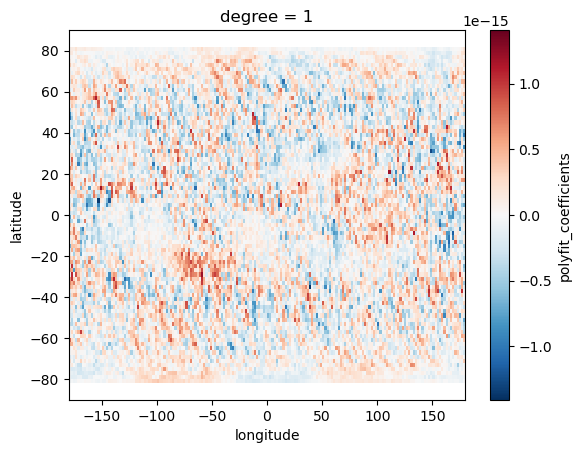

In [130]:
(trends_day_xr.isel(month=9).sel(degree=1)['polyfit_coefficients'] * 1000).plot.pcolormesh() # percent/decade

In [131]:
m = xday.time.dt.month
oct = xday.isel(time=(m==10))
# mean values
# oct.mean(dim='time').plot.pcolormesh()

oct_trend = get_trend_map(oct, deg=1).compute()
oct_trend

<xarray.Dataset> Size: 260kB
Dimensions:               (latitude: 90, longitude: 180, degree: 2)
Coordinates:
  * latitude              (latitude) float32 360B -89.0 -87.0 ... 87.0 89.0
  * longitude             (longitude) float32 720B -179.0 -177.0 ... 177.0 179.0
  * degree                (degree) int64 16B 1 0
Data variables:
    polyfit_coefficients  (degree, latitude, longitude) float64 259kB nan ......

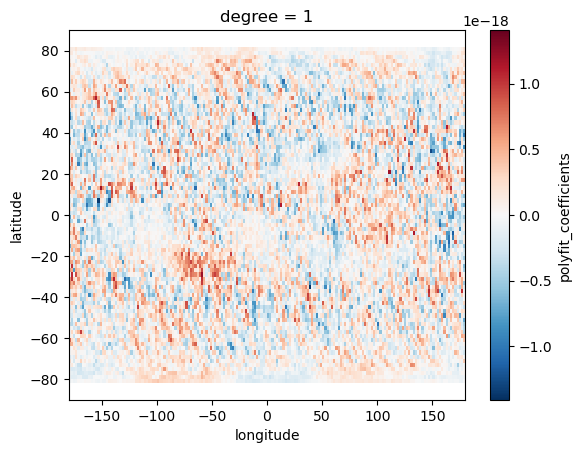

In [132]:
oct_trend['polyfit_coefficients'].sel(degree=1).plot.pcolormesh()

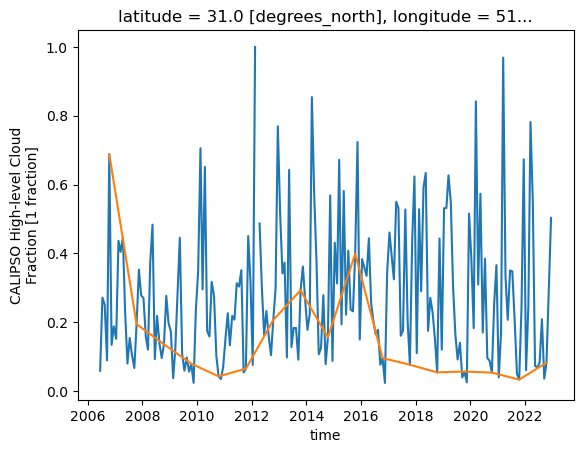

In [133]:
xday.sel(latitude=30, longitude=50, method='nearest').plot()
oct.sel(latitude=30, longitude=50, method='nearest').plot()

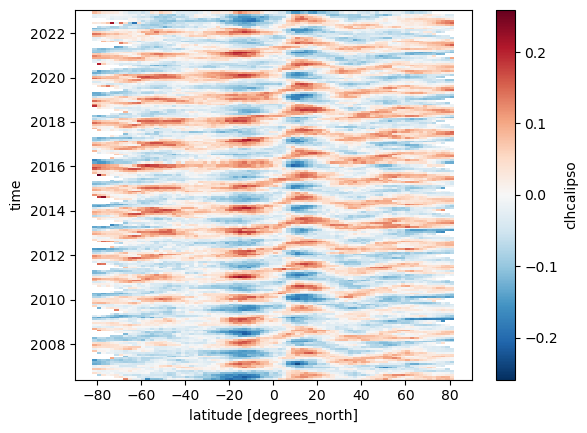

In [134]:
xday_zm = xday.mean(dim='longitude')
xday_zm_anom = xday_zm - xday_zm.mean(dim='time')
xday_zm_anom.plot.pcolormesh()

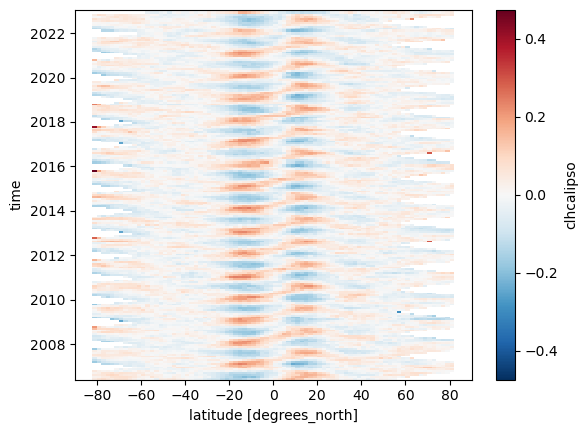

In [135]:
xnight_zm = xnight.mean(dim='longitude')
xnight_zm_anom = xnight_zm - xnight_zm.mean(dim='time')
xnight_zm_anom.plot.pcolormesh()

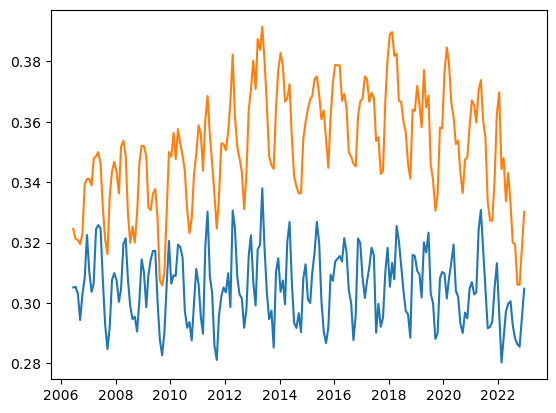

In [143]:
coslat = np.cos(np.radians(xday.latitude))

global_mean_day = xday.weighted(coslat).mean(dim=("latitude","longitude"))
global_mean_nit = xnight.weighted(coslat).mean(dim=("latitude","longitude"))

fig, ax = plt.subplots()
ax.plot(global_mean_nit.time, global_mean_nit)
ax.plot(global_mean_day.time, global_mean_day)

In [145]:
xday.isel(time=xday.time.dt.year==2020)

<xarray.DataArray 'clhcalipso' (time: 12, latitude: 90, longitude: 180)> Size: 778kB
dask.array<getitem, shape=(12, 90, 180), dtype=float32, chunksize=(1, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 360B -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
  * longitude  (longitude) float32 720B -179.0 -177.0 -175.0 ... 177.0 179.0
  * time       (time) datetime64[ns] 96B 2020-01-15 2020-02-15 ... 2020-12-15
Attributes:
    long_name:     CALIPSO High-level Cloud Fraction
    units:         1 fraction
    cell_methods:  time: mean